In [1]:
import os 
import math 
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import requests

In [2]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms



In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
class PatchEmbed(nn.Module): 
    
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        assert img_size % patch_size == 0, 'image size must be divided by patch size'
        
        self.embed_dim = embed_dim 
    
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size = patch_size, stride = patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,self.embed_dim))
        self.position_embedding = nn.Parameter(torch.randn((img_size//patch_size)**2 + 1, self.embed_dim)) 
        
    def forward(self, x): 
        """
        Args: 
            x: input image (batch_size x 3 x 224 x 224)
        """
        
        batch_size, channels, img_size = x.shape[0], x.shape[1], x.shape[2]
        
        x = self.proj(x) # (batch_size x 3 x 224 x 224) --> (batch_size x 768 x 14 x 14) 
        
        x = x.view(batch_size, self.embed_dim, -1)  # (batch_size x 768 x 14 x 14) --> (batch_size x 768 x 196)
        
        x = x.permute(0, 2, 1)   # (batch_size x 768 x 196) --> (batch_size x 196 x 768)
        
        cls_token = self.cls_token.repeat(batch_size, 1, 1)  # (1 x 1 x 768) --> (batch_size x 1 x 768)
        
        x = torch.cat([cls_token, x], dim = 1) # (batch_size x 197 x 768)
        
        x += self.position_embedding 
        
        return x
        
        
        
        

In [5]:
class MultiHeadAttention(nn.Module): 
    
    def __init__(self, embed_dim = 768, n_heads = 12): 
        
        super().__init__()
        
        assert embed_dim % n_heads == 0, 'the dimension of emebdding vector must be divided by attention head number'
        
        self.embed_dim = embed_dim 
        self.head_num = n_heads 
        self.scale = (self.embed_dim//self.head_num) ** -0.5 
        
        self.qkv = nn.Linear(embed_dim, embed_dim*3, bias = False) 
        self.proj = nn.Linear(embed_dim, embed_dim, bias = False) 
        self.drop = nn.Dropout(0.1)
        
    def forward(self, x): 
        """
        Args:
            x: input embedded patches plus the cls_token; 4 x 197 x 768 
        """
        B, N, C = x.shape 
        
        qkv = self.qkv(x).reshape(B, N, 3, self.head_num, C//self.head_num).permute(2,0,3,1,4) 
        # (4 x 197 x 768) --> (4 x 197 x (3 x 768)) --> (4 x 197 x 3 x 12 x 64) --> (3 x 4 x 12 x 197 x 64)
        
        q, k, v = qkv[0], qkv[1], qkv[2] # (4 x 12 x 197 x 64) 
        
        attn = torch.matmul(q, k.transpose(-1,-2))*self.scale  # (4 x 12 x 197 x 197)
        
        scores = F.softmax(attn, dim = -1)
      
        x = torch.matmul(scores, v).permute(0, 2, 1,3).reshape(B, N, -1) # (4 x 12 x 197 x 64) --> (4 x 197 x 12 x 64) --> (4 x 197 x 768)
        
        x = self.proj(x)
        x = self.drop(x)
        return x

In [6]:
class TransformerBlock(nn.Module):
    
    def __init__(self, embed_dim=768, n_heads=12, expansion_factor=4):
        super().__init__()
        self.embed_dim = embed_dim 
        self.head_num = n_heads
        self.expansion_factor = expansion_factor 
        
        self.attention = MultiHeadAttention(self.embed_dim, self.head_num)
        
        self.mlp = nn.Sequential(
            nn.Linear(self.embed_dim, expansion_factor*self.embed_dim), 
            nn.GELU(), 
            nn.Dropout(0.1),
            nn.Linear(expansion_factor*self.embed_dim, self.embed_dim),
            nn.Dropout(0.1))
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        
    def forward(self, x): 
        
        """
        Args: 
            x: embedded patch vector (32 x 197 x 768)
        """
        x = self.attention(self.norm1(x)) + x 
        
        x = self.mlp(self.norm2(x)) + x
        
        return x 
        

In [7]:
class ClassificationHead(nn.Module):
    
    def __init__(self, embed_dim, n_classes): 
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, n_classes)
        
    def forward(self, x): 
        
        x = self.norm(x)
        x = self.fc(x)
        return x

In [8]:
class VisionTransformer(nn.Module): 
    def __init__(self, 
                 img_size=224, patch_size=16, in_channels=3, 
                 embed_dim=768, n_heads=12, expansion_factor=4, L=6, 
                 n_classes = 100): 
        super().__init__()
        
        self.patch_embed = PatchEmbed(img_size = img_size, patch_size = patch_size, in_channels = in_channels, embed_dim = embed_dim)
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, n_heads, expansion_factor) for _ in range(L)])
        self.mlp_head = ClassificationHead(embed_dim, n_classes)
        
    def forward(self, x): 
        """
        Args:
            x: patched and embeded image vector 4 x 3 x 224 x 224
        """
        x = self.patch_embed(x)
        for layer in self.layers: 
            x = layer(x) 
        # x dimension is 4 x 197 x 768
        out = self.mlp_head(x[:, 0,:])
        return out

In [9]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return 

transform =  transforms.Compose([
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])
train_data_path = "./data/Fish-vs-Cats/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transform, is_valid_file=check_image)

val_data_path = "./data/Fish-vs-Cats/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=transform, is_valid_file=check_image)

test_data_path = "./data/Fish-vs-Cats/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=transform, is_valid_file=check_image)


# Random Plots

In [10]:
train_data_list = list(iter(train_data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


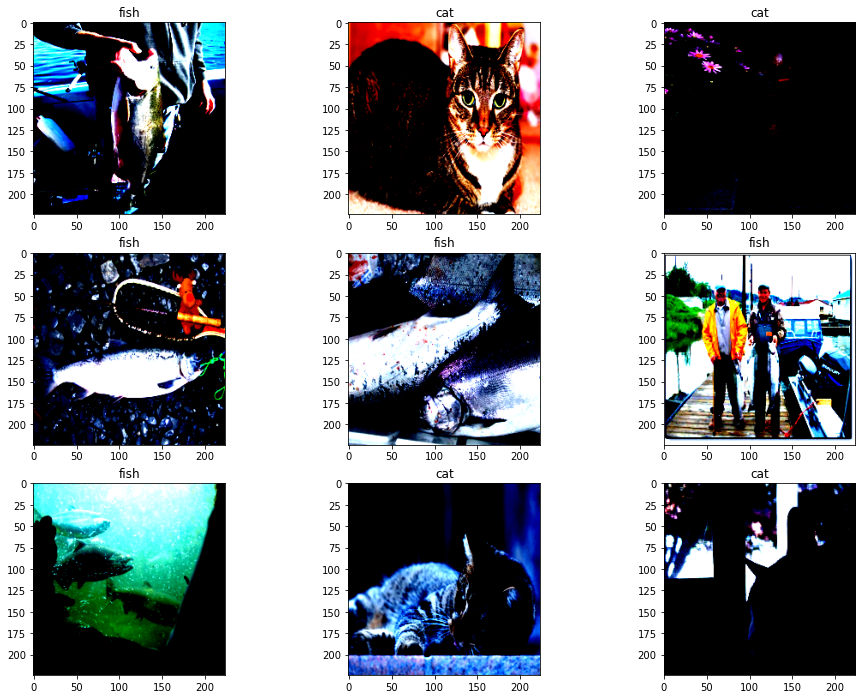

In [11]:
label_dict = {0:'cat', 1:'fish'}

random_idx = np.random.randint(1, len(train_data), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    
    image = train_data_list[random_idx[idx]][0]
    label = label_dict[train_data_list[random_idx[idx]][1]]

    ax.set_title(label)
    ax.imshow(image.permute((1,2,0)))

In [12]:
BATCH_SIZE = 4
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader=DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

# Training

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = VisionTransformer(n_classes = 2)
model.to(device)
# loss function 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0003)
scheduler = StepLR(optimizer, step_size = 10, gamma=0.95)

In [16]:
for epoch in range(101): 
    train_loss = 0
    accuracy = 0
    for data, label in train_dataloader: 
        
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        acc = (output.argmax(dim = 1) == label).float().mean()
        
        train_loss += loss.item()/len(train_dataloader)
        accuracy += acc/len(train_dataloader)
    scheduler.step()    
    
    with torch.no_grad(): 
        val_loss = 0
        val_accuracy = 0 
        for data, label in validation_dataloader: 
            
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            loss = criterion(val_output, label) 
            
            acc = (val_output.argmax(dim=1) == label).float().mean()
            val_loss += loss.item()/len(validation_dataloader)
            val_accuracy += acc/len(validation_dataloader)
    if epoch % 10 == 0:
        print('epoch: %d, loss: %.3f, accuracy: %.3f, loss on validation set: %.3f, accuracy on validation set: %.3f' % (epoch, train_loss, accuracy, val_loss, val_accuracy))

epoch: 0, loss: 0.766, accuracy: 0.619, loss on validation set: 0.473, accuracy on validation set: 0.804
epoch: 10, loss: 0.515, accuracy: 0.738, loss on validation set: 0.348, accuracy on validation set: 0.804
epoch: 20, loss: 0.462, accuracy: 0.792, loss on validation set: 0.409, accuracy on validation set: 0.830
epoch: 30, loss: 0.371, accuracy: 0.846, loss on validation set: 0.384, accuracy on validation set: 0.848
epoch: 40, loss: 0.377, accuracy: 0.847, loss on validation set: 0.375, accuracy on validation set: 0.830
epoch: 50, loss: 0.396, accuracy: 0.833, loss on validation set: 0.419, accuracy on validation set: 0.777
epoch: 60, loss: 0.345, accuracy: 0.858, loss on validation set: 0.376, accuracy on validation set: 0.830
epoch: 70, loss: 0.318, accuracy: 0.882, loss on validation set: 0.692, accuracy on validation set: 0.804
epoch: 80, loss: 0.321, accuracy: 0.856, loss on validation set: 0.439, accuracy on validation set: 0.768
epoch: 90, loss: 0.248, accuracy: 0.903, loss o

In [17]:
len(test_dataloader)

40

In [20]:
with torch.no_grad(): 
        
        accuracy = 0
        for data, label in test_dataloader: 
            
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            
            acc = (output.argmax(dim=1) == label).float().mean()
            accuracy += acc/len(test_dataloader)
print("the prediction accuracy on test dataset is: %f" %accuracy)

the prediction accuracy on test dataset is: 0.737500


In [22]:
import copy
best_model_wts = copy.deepcopy( model.state_dict() )
torch.save( best_model_wts,'best_model_weight_vit.pth') 